In [1]:
import os, cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import xml.etree.ElementTree as ET


In [2]:
path = "/home/mlut/IDLCV/object_detection/Potholes/annotated-images/" #egen sti til eget data

In [7]:
images = []
for e,i in enumerate(os.listdir(path)): #git directory where data is stored
    if i.endswith(".jpg"): #input something
        image = cv2.imread(os.path.join(path,i))
        resized_img = cv2.resize(image, [128,128])
        images.append(resized_img)
        #images.append(image)
        

In [4]:
#selective
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [5]:
def get_iou(bb1, bb2):

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou
    

In [6]:
ssresults_dict = {}  
for i in range(len(images)):
    image = images[i]
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()  # Region proposals for the image
    
    # Store the results in the dictionary with the iteration number as the key
    ssresults_dict[i] = ssresults


KeyboardInterrupt: 

In [ ]:
ssresults_list = []
for image in images:
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process() 
    ssresults_list.append(ssresults)

In [ ]:
bounding_boxes_dict = {}  # Dictionary to store the bounding boxes

xml_counter = 0  # Counter for XML files

for i in os.listdir(path): 
    if i.endswith(".xml"): 
        xml_file = os.path.join(path, i)
        tree = ET.parse(xml_file)
        root = tree.getroot()
        list_with_all_boxes = []  # List to store the bounding boxes for the current file

        filename_element = root.find('filename')
        filename = filename_element.text if filename_element is not None else None

        for boxes in root.iter('object'):  # Assuming bounding boxes are under 'object' tags
            ymin, xmin, ymax, xmax = None, None, None, None

            ymin_element = boxes.find("bndbox/ymin")
            xmin_element = boxes.find("bndbox/xmin")
            ymax_element = boxes.find("bndbox/ymax")
            xmax_element = boxes.find("bndbox/xmax")

            if all(element is not None for element in [ymin_element, xmin_element, ymax_element, xmax_element]):
                ymin = int(ymin_element.text)
                xmin = int(xmin_element.text)
                ymax = int(ymax_element.text)
                xmax = int(xmax_element.text)
                list_with_single_boxes = [xmin, ymin, xmax, ymax]
                list_with_all_boxes.append(list_with_single_boxes)
        
        if list_with_all_boxes:
            bounding_boxes_dict[xml_counter] = list_with_all_boxes
            xml_counter += 1 

# Now 'bounding_boxes_dict' contains each list of bounding boxes, mapped by the iteration number


In [ ]:
#Det er det her loop jeg har forsøgt at skrive der skal sammenligne bounding-box koordinaterne med proposals, men det virker ikke helt
best_predictions = {}

for key in bounding_boxes_dict:
    x_true, y_true, w_true, h_true = bounding_boxes_dict[key][0]  
    best_iou = 0
    best_prediction = None

    for pred in ssresults_dict[key]:  
        x_pred, y_pred, w_pred, h_pred = pred

        iou = get_iou({"x1": x_true, "y1": y_true, "x2": x_true + w_true, "y2": y_true + h_true},
                      {"x1": x_pred, "y1": y_pred, "x2": x_pred + w_pred, "y2": y_pred + h_pred})

        if iou > best_iou:
            best_iou = iou
            best_prediction = pred

    if best_prediction is not None:
        best_predictions[key] = best_prediction


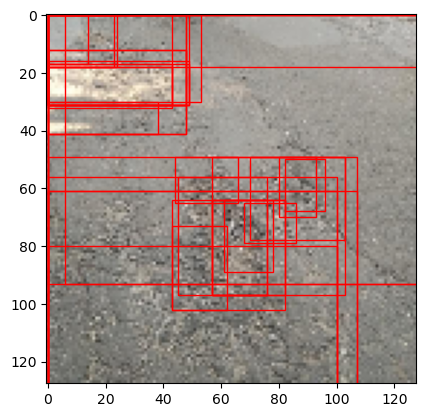

In [ ]:
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Loop through each region proposal
for (x, y, w, h) in ssresults:
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the rectangle to the Axes
    ax.add_patch(rect)

# Show the plot with all region proposals
plt.savefig("First try on region proposals")
plt.show()


In [ ]:
#List train_labels now contains the learned, not GT, labels of the proposals. Evaluate these against the dataset labels